In [2]:
import numpy as np 
from numba import njit, prange
import random
import matplotlib.pyplot as plt 
import math

0.9990487326049873


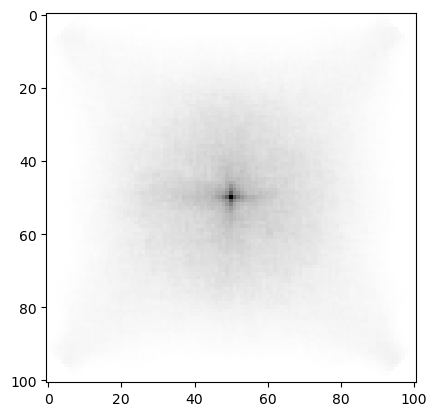

In [7]:
# Constants
GRID_SIZE = 100
RADIUS = GRID_SIZE//2
SEED = (GRID_SIZE // 2, GRID_SIZE // 2)  # Seed in the middle of the grid
TIMESTEPS = 50000
NUM_SIMS = 1000
Temp = 25
RH = 97
Min_Temp = 0.1
Max_Temp = 50 
Min_RH = 80
Max_RH = 100 

def attaching_prob(Temp, RH, Min_temp, Max_temp, Min_RH, Max_RH): 
    return (Temp**(-0.68) * RH**(-13.9) - (Min_temp**(-0.68) * Min_RH**(-13.9))) / ((Max_temp**(-0.68) * Max_RH**(-13.9)) - (Min_temp**(-0.68) * Min_RH**(-13.9)))

ATTACH_PROB = attaching_prob(Temp, RH, Min_Temp, Max_Temp, Min_RH, Max_RH)

@njit # This decorator tells Numba to compile this function using the JIT (just-in-time) compiler
def particle_loop(GRID_SIZE, RADIUS, grid, ATTACH_PROB, TIMESTEPS):
    current_radius = 5 #spawns particles closer to where the seed is, to speed up the program. 
    for _ in range(TIMESTEPS):
        # Create the particle starting from a random point on the circle
        angle = random.uniform(0, 2 * math.pi) # Random angle in radians
        particle = (int(GRID_SIZE/2 + current_radius * math.cos(angle)), int(GRID_SIZE/2 + current_radius * math.sin(angle))) #use angle and spawn point of seed (which is the middle of the grid) ...
        # ... to calculate the x and y coordinates of a new particle. Cast it to int also. 

        while True:
            # Check if particle is out of bounds (ensure it's within grid size)
            if particle[0] < 0 or particle[1] < 0 or particle[0] >= GRID_SIZE or particle[1] >= GRID_SIZE:
                break

            # Check if the particle can attach to any adjacent grid cell (touches the cluster)
            if (grid[particle[0] + 1, particle[1]] == 1 or
                grid[particle[0] - 1, particle[1]] == 1 or
                grid[particle[0], particle[1] + 1] == 1 or
                grid[particle[0], particle[1] - 1] == 1):

                # dist_to_seed = math.sqrt((particle[0] - GRID_SIZE/2) ** 2 + (particle[1] - GRID_SIZE/2) ** 2)
                if np.random.uniform() < ATTACH_PROB:
                    grid[particle[0], particle[1]] = 1  # Attach particle to the grid

                dist_to_seed = math.sqrt((particle[0] - GRID_SIZE/2) ** 2 + (particle[1] - GRID_SIZE/2) ** 2)
                if dist_to_seed >= current_radius-1:
                    current_radius += 10
                break  # Once attached, stop particle movement and move to the next particle

            # Move the particle randomly until we break the loop manually
            move = np.random.randint(0, 4)  # Randomly select one of four directions
            if move == 0:
                particle = (particle[0], particle[1] + 1)  # Move up
            elif move == 1:
                particle = (particle[0] + 1, particle[1])  # Move right
            elif move == 2:
                particle = (particle[0], particle[1] - 1)  # Move down
            elif move == 3:
                particle = (particle[0] - 1, particle[1])  # Move left


@njit(parallel=True)
def monte_carlo(GRID_SIZE, RADIUS, ATTACH_PROB, TIMESTEPS, NUM_SIMS):
    print(ATTACH_PROB)
    aggr_grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1))
    for _ in prange(NUM_SIMS):
        # Initialize grid (plus 1 to account for 0-index)
        grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1))
        grid[SEED[0], SEED[1]] = 1  # Set seed point as part of cluster
        particle_loop(GRID_SIZE, RADIUS, grid, ATTACH_PROB, TIMESTEPS)
        aggr_grid += grid

    return aggr_grid / NUM_SIMS


final_grid = monte_carlo(GRID_SIZE, RADIUS, ATTACH_PROB, TIMESTEPS, NUM_SIMS)
# Plot the result
plt.imshow(final_grid, cmap='Greys', interpolation='nearest')
plt.show()
